In [44]:
import json
import time
import glob
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
from scipy.stats import moment
from itertools import permutations
from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import clear_output


In [54]:
timeout = 120
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

def r(task):
    ind = 0
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def p(task):
    ind = 1
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def d(task):
    ind = 2
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def remove(arr, elem):
    return np.delete(arr, np.where(np.in1d(arr, elem)))

class TaskSet:
    
    def __init__(self, a):
        if isinstance(a, int):
            rs = np.cumsum(np.random.exponential(scale=1/LAMBDA, size=(a,)))
            ps = np.clip(np.random.normal(MU, SIGMA, size=(a,)), a_min=0, a_max=None)
            ds = [r + VARK*moment(ps, moment=2) for r in rs]
            self.array = np.array([rs, ps, ds]).T.astype(float)
        else:
            self.array = np.copy(a)
            
    def __repr__(self):
        return "  r  |  p  |  d  \n" + str(self.array)
    
    def copy(self):
        return TaskSet(self.array)
    
    def __getitem__(self, key):
        return TaskSet(self.array[key])
    
    def __iter__(self):
        return iter(self.array)
    
    def C(self, i, tau=0):
        t = tau
        for task in self.array[:i+1]:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def C_max(self, tau=0):
        t = tau
        for task in self.array:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def L(self, i=None, tau=0):
        if i is None:
            return self.C_max(tau) - d(self[-1])
        return self.C(i, tau) - d(self[i])
    
    def L_max(self, tau=0):
        if len(self) == 0: return float('inf')
        return max([self.L(i, tau) for i, _ in enumerate(self)])
    
    def T(self, i=None, tau=0):
        return max(0, self.L(i, tau))
    
    def T_max(self, tau=0):
        return max(0, self.L_max(tau))
    
    def __len__(self):
        return len(self.array)
    
    def __eq__(self, other):
        return self.array == other
    
    def without(self, indexes):
        return TaskSet(np.delete(self.array, np.array(indexes).astype(float), axis=0))
    
    def find(self, item):
        return np.where((self.array == item).all(axis=1))[0]
    
    def transpose(self):
        return self.array.T
    
    def scale_r(self, alpha):
        self.array[:,0] = self.array[:,0]*alpha
        return self


In [5]:
def greedy(s):
    pi1 = []
    pi2 = []
    bestLmax = float('inf')

    for j in range(len(s)):
        for i in range(len(s)):
            if i not in pi1 and i not in pi2:
                tPi1 = pi1.copy()
                tPi2 = pi2.copy()
                tPi1.append(i)
                tPi2.append(i)
                if max(s[tPi1].L_max(), s[pi2].L_max()) < bestLmax:
                    pi1 = tPi1.copy()
                    bestLmax = max(s[tPi1].L_max(), s[pi2].L_max())
                elif max(s[tPi2].L_max(), s[pi1].L_max()) < bestLmax:
                    pi2 = tPi2.copy()
                    bestLmax = max(s[tPi2].L_max(), s[pi1].L_max())
                elif max(s[tPi1].L_max(), s[pi2].L_max()) > max(s[tPi2].L_max(), s[pi1].L_max()):
                    pi2 = tPi2.copy()
                    bestLmax = max(s[tPi2].L_max(), s[pi1].L_max())
                else:
                    pi1 = tPi1.copy()
                    bestLmax = max(s[tPi1].L_max(), s[pi2].L_max())
    return bestLmax, pi1, pi2


In [26]:
def bruteforce(s):
    bestPi1 = []
    bestPi2 = []
    pi = [i for i in range(len(s))]
    bestLmax = float('inf')
    for perm in permutations(pi):
        for i in range(len(s)+1):
            pi1 = perm[:i]
            pi2 = perm[i:]
            #print(pi1, pi2)
            if len(pi1) == 0:
                tLmax = s[list(pi2)].L_max()
            elif len(pi2) == 0:
                tLmax = s[list(pi1)].L_max()
            else:
                tLmax = max(s[list(pi1)].L_max(), s[list(pi2)].L_max())
            if tLmax < bestLmax:
                bestLmax = tLmax
                bestPi1 = list(pi1).copy()
                bestPi2 = list(pi2).copy()
    return bestLmax, bestPi1, bestPi2

In [35]:
N_TASKS = 1000
results = []
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
for i in range(N_TASKS):
    s = TaskSet(5)
    gL = greedy(s)[0]
    bL = bruteforce(s)[0]
    if gL < bL: raise RuntimeError("Smth wrong with bruteforce")
    results.append(gL/bL)
    pBar.value += 1

IntProgress(value=0, max=1000)

In [53]:
print("Средняя ошибка 'жадного' алгоритма: %.2f" % (np.mean(1 - np.array(results))*100), "%")

Средняя ошибка 'жадного' алгоритма: 0.79 %


In [66]:
global approxResults
global realResult
def test_schedule(alpha_arr):
    global approxResults
    global realResult
    approxResults = []
    s = TaskSet(10)
    for a in alpha_arr:
        #print("\ra =", a, end='')
        scaled_s = s.copy().scale_r(a)
        #flattenedScaled_s = list(map(lambda x: x.array.flatten(), scaled_s))
        Lmax = greedy(scaled_s)[0]
        approxResults.append((a, Lmax))
    realResult = (1., greedy(s)[0])
    approxResults = np.array(approxResults)
    return approxResults[:,1]

IntProgress(value=0, max=12)

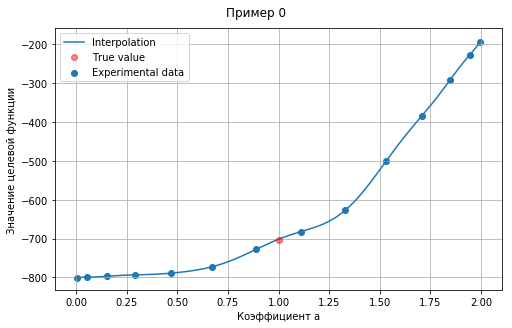

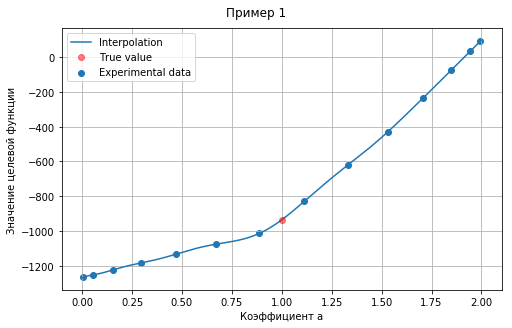

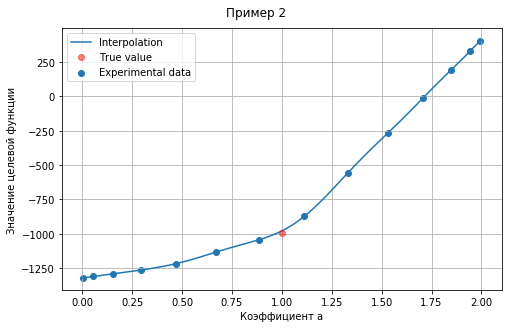

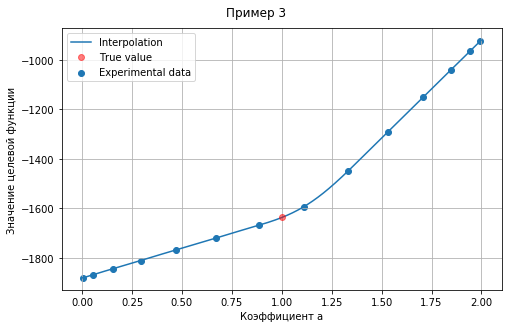

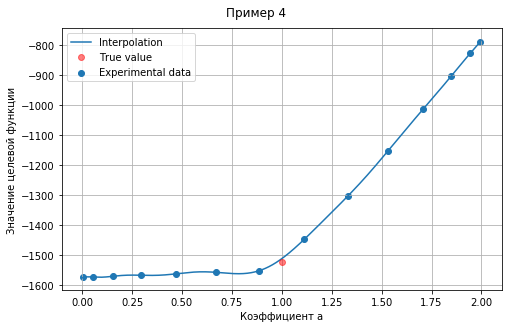

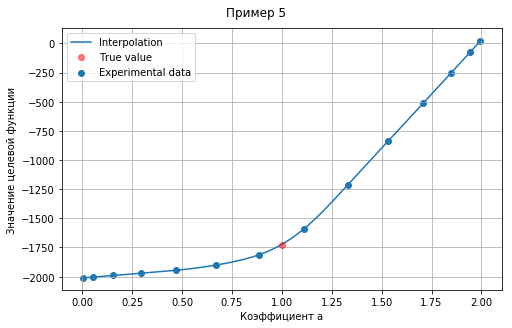

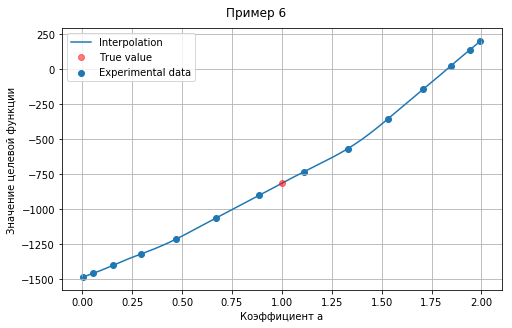

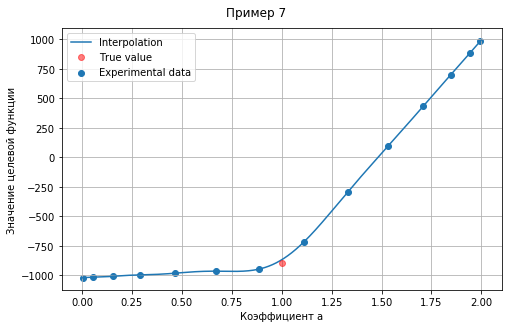

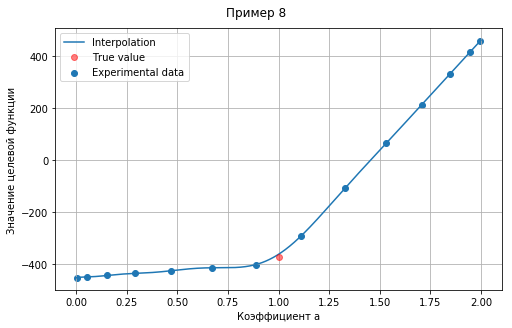

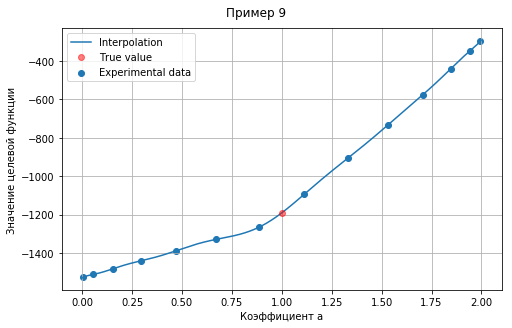

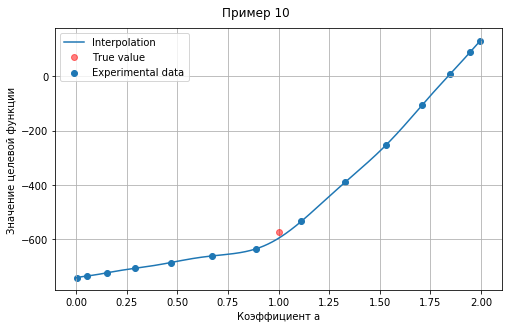

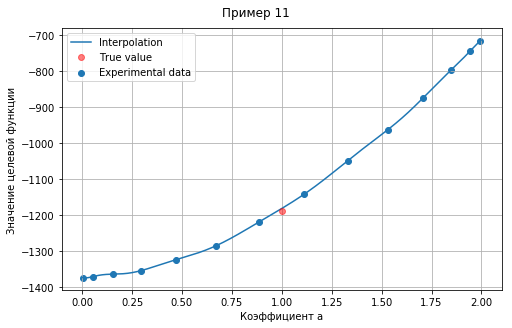

In [68]:
N_TASKS = 12
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
global realResult
global approxResults
for i in range(N_TASKS):
    C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
    approxResults = np.array(approxResults)
    
    x = approxResults[:,0]
    y = approxResults[:,1]
    xp = np.arange(0, 2, 0.001)
    yp = C(xp)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
    fig.suptitle("Пример %s" % i)
    axes.scatter(x, y, label="Experimental data")
    axes.plot(xp, yp, label="Interpolation")
    axes.grid()
    axes.set_xlabel("Коэффициент а")
    axes.set_ylabel("Значение целевой функции")
    axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
    axes.legend()
    pBar.value += 1

In [69]:
N_TASKS = 200
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
global realResult
global approxResults
results = []
for i in range(N_TASKS):
    C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
    results.append((C(1.) - realResult[1])/realResult[1]*100)
    pBar.value += 1
with open("ChebyshevParallelEfficiencyResults.json", 'w') as f:
    json.dump(results, f)

IntProgress(value=0, max=200)

In [70]:
with open("ChebyshevParallelEfficiencyResults.json", 'r') as f:
    results = json.load(f)
pd.DataFrame([[max(np.abs(results)), min(np.abs(results)), np.mean(np.abs(results)), np.mean(results)]], columns=["Максимум модуля отклонения, %", "Минимум модуля отклонения, %", "Средний модуль отклонения, %", "Среднее отклонение, %"])

,"Максимум модуля отклонения, %","Минимум модуля отклонения, %","Средний модуль отклонения, %","Среднее отклонение, %"
0,20.803001,0.001872,1.345859,-0.655165
